### Abstract

In this blog post we are going to train a random forest model to classify penguin species based on three features in the Palmer Penguins dataset. We'll start with some visualizations to get an understanding of the different features in the dataset, and then we will use a random forest to choose the best three features to train our model on. After training and testing the model, we will explore how well the model did and how it made its classifications using the confusion matrix and plotting decision regions. 

### Preparing the Data

In [100]:
#| include: false

# Imports
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from sklearn.metrics import confusion_matrix

In [101]:
# Read in the data
train_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/train.csv"
train = pd.read_csv(train_url)

In [102]:
le = LabelEncoder()
train["Species"].replace('Adelie Penguin (Pygoscelis adeliae)','Adelie',inplace=True)
train["Species"].replace('Chinstrap penguin (Pygoscelis antarctica)','Chinstrap',inplace=True)
train["Species"].replace('Gentoo penguin (Pygoscelis papua)','Gentoo',inplace=True)
le.fit(train["Species"])

# Function to prepare the data 
def prepare_data(df):
  df = df.drop(["studyName", "Sample Number", "Individual ID", "Date Egg", "Comments", "Region"], axis = 1) # Remove unnecessary columns
  df = df[df["Sex"] != "."]                                                                                 
  df = df.dropna() # Drop NAs                                                                                          
  y = le.transform(df["Species"]) # Encode the species column                                                                      
  df = df.drop(["Species"], axis = 1)                                                                       
  df = pd.get_dummies(df) # One-hot encode the boolean columns                                                                
  return df, y

X_train, y_train = prepare_data(train)

In the above code, we processed the dataset to prepare it for analysis as follows:
* Remove the unnecessary columns and NAs
* Prepare the qualitative columns for analysis by encoding them as quantitative columns 
    + Encode the species column
        - Each species is assigned a number 
    + "One-hot encode" the boolean columns
        - The get_dummies function converts these columns to 0-1 instead of True/False

In [103]:
#| echo: false

X_train.head()

,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Delta 15 N (o/oo),Delta 13 C (o/oo),Island_Biscoe,Island_Dream,Island_Torgersen,"Stage_Adult, 1 Egg Stage",Clutch Completion_No,Clutch Completion_Yes,Sex_FEMALE,Sex_MALE
0,40.9,16.6,187.0,3200.0,9.08458,-24.54903,False,True,False,True,False,True,True,False
1,49.0,19.5,210.0,3950.0,9.53262,-24.66867,False,True,False,True,False,True,False,True
2,50.0,15.2,218.0,5700.0,8.25540,-25.40075,True,False,False,True,False,True,False,True
3,45.8,14.6,210.0,4200.0,7.79958,-25.62618,True,False,False,True,False,True,True,False
4,51.0,18.8,203.0,4100.0,9.23196,-24.17282,False,True,False,True,False,True,False,True


### Visualizing the data

Now, we need to figure out which features best distinguish each species so that we can train a model to predict the species based on the features. 
We'll start by looking at visualizations of some of the features in the dataset in order to get an idea of which ones will work well for classification. 

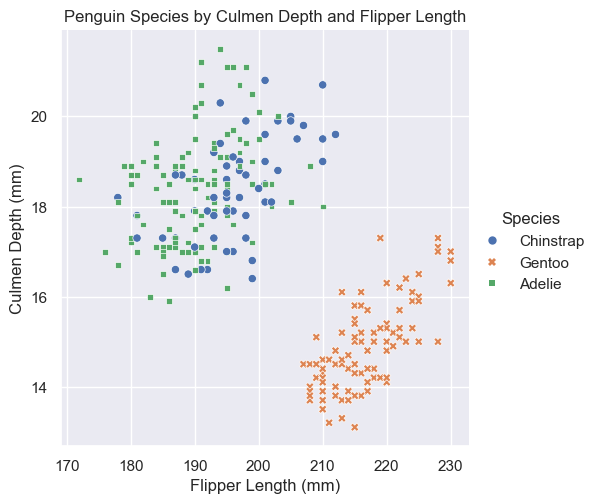

In [104]:
#| label: culmen-flipper
#| fig-cap: "Figure 1: culmen length and flipper depth of each penguin species"

sns.set_theme()
# Plot the culmen depth and flipper length 
sns.relplot(
    data=train,
    x="Flipper Length (mm)", y="Culmen Depth (mm)",
    hue="Species", style="Species"
).set(title="Penguin Species by Culmen Depth and Flipper Length")

[Text(0, 0, 'Dream'), Text(1, 0, 'Biscoe'), Text(2, 0, 'Torgersen')]

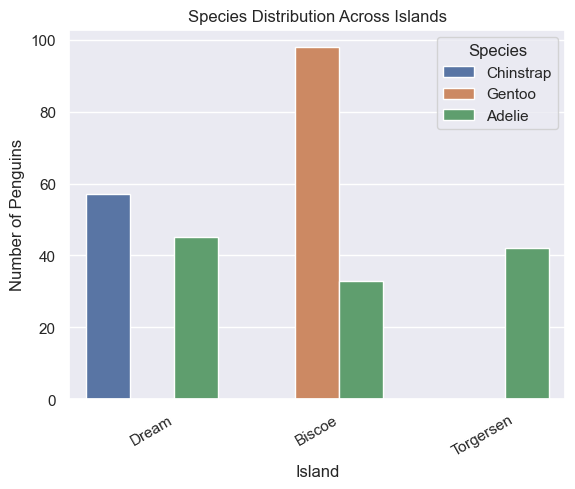

In [105]:
#| label: species-dist
#| fig-cap: "Figure 2: species distribution across each island"

# Plot the distribution of each species on each of the 3 islands 
ax = sns.countplot(data=train, x="Island", hue="Species")
ax.set(xlabel="Island", ylabel="Number of Penguins", title="Species Distribution Across Islands")
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

In [106]:
#| echo: false
#| label: culmen-mean-length
#| fig-cap: "Figure 3: mean culmen length by species"

# Use group by to make a table of the average culmen length by species 
grouped_data = train.groupby("Species").agg({"Culmen Length (mm)" : "mean"})
grouped_data

,Culmen Length (mm)
Species,
Adelie,38.970588
Chinstrap,48.826316
Gentoo,47.073196


Our goal is to find three features that will allow us to train a model which will be 100% accurate in predicting the species of a penguin in the training set. We can ascertain some information about the top scored features from these plots that will be helpful to determine if these features will work. 

 First, as we can see in Figure 1, the Gentoo penguin has different culmen and flipper measurements than the Chinstrap and Adelie penguins. Specifically, the Gentoo penguin seems to have a larger flipper length and a shallower culmen depth than the Chinstrap and Adelie penguins. This relationship could be used to identify the Gentoo penguins, but we still need to find a way to distinguish between the Chinstrap and Adelie penguins. 
 
 Figure 2 provides a way to do this; the Chinstrap penguins are only found on Dream Island. We can also see that the Adelie penguins are found on all three islands, and the Gentoo penguin is only found on Biscoe Island. In the summary table, we can see that there is also a difference in culmen length between the species. The Chinstrap and Gentoo penguins have similar average culmen lengths, but the Adelie penguins have much shorter culmens on average.  

Using some combination of these features, we should be able to accurately predict the species of any penguin in the training set. We will use tree-based feautre selection to determine which of the features we will use to train our model. 

### Optimizing model parameters

We will be using a random forest to choose the best features to train our model on. We'll also use a random forest to execute our classification. First, let's understand what a random forest is: 

**Random Forest**
: Random forests are an ensemble learning method. That is, they combine predictions from multiple models to make a final prediction. Random forests use multiple decision trees to make a prediction. Each tree is trained on a different subset of the training set, so different trees can learn different patterns in the data. The trees use a process of "voting" to determine the prediction--whichever species is predicted by the most trees is the final prediction.

#### Choosing the best features

In [107]:
# Fit a model to find the best features in the training set
tree_selector = ExtraTreesClassifier(n_estimators=100, random_state=42)
tree_selector.fit(X_train, y_train)
feature_importances = tree_selector.feature_importances_

# Create DataFrame with the feature and its importance score
feature_scores = pd.DataFrame({"Feature": X_train.columns, "Importance": feature_importances})
feature_scores = feature_scores.sort_values(by="Importance", ascending=False)

In [108]:
#| echo: false

print("Top 3 Features:")
print(feature_scores.head(3))

Top 3 Features:
               Feature  Importance
0   Culmen Length (mm)    0.166972
2  Flipper Length (mm)    0.139796
6        Island_Biscoe    0.132696


When we use the ExtraTreesClassifier function, we are building a random forest from the training set. A random subset of features is used for each tree, then the best features are selected based on an importance score. The importance score is calculated using an impurity score for each feature that captures how well a feature is able to partition the dataset. These scores are then normalized to create the importance score. We can see from the feature selector that the culmen length, flipper length, and the island are the most important features in the dataset. So, we will use these features to train our model. 

#### Choosing maximum tree depth

One of the parameters for any tree method is the maximum depth at which the tree can go. That is, the number of partitions of the dataset allowed in each tree. In order to find the optimal maximum depth, we will use cross validation to test a range of potential maximum depths:

In [109]:
# The columns that we want to include in our analysis -- based on the highest-scoring features
cols = ["Flipper Length (mm)", "Culmen Length (mm)", "Island_Biscoe", "Island_Dream","Island_Torgersen"]

depths = range(1, 21)
mean_scores = []

# Loop through potential depths and use cross validation to score each depth
for depth in depths:
    dt = RandomForestClassifier(max_depth=depth, random_state=42)
    scores = cross_val_score(dt, X_train[cols], y_train, cv=5, scoring='accuracy')
    mean_scores.append(np.mean(scores))

# Find the depth with the highest scoring validation
best_depth = depths[np.argmax(mean_scores)]
best_score = max(mean_scores)

In [110]:
#| echo: false

print(f"Best max tree depth: {best_depth}")
print(f"Best cross-validated accuracy: {best_score}")

Best max tree depth: 7
Best cross-validated accuracy: 0.9843891402714933


Based on the cross-validation, a random forest with maximum depth 7 is the best option for our model.

### Fitting the model

Now that we know which features we want to use and have done some work to optimize the parameters for our random forest, we're ready to train a random forest on our training set. 

In [111]:
# Initialize the model and fit it to the train set
dt_model = RandomForestClassifier(max_depth=5, random_state=42)
dt_model.fit(X_train[cols], y_train)

# Score the model accuracy to see how well it did 
train_accuracy = dt_model.score(X_train[cols], y_train)


In [112]:
#| echo: false

print(f"Training Accuracy: {train_accuracy:.4f}")

Training Accuracy: 0.9961


This random forest works pretty well! It was 99% accurate on our testing set. Now that we've trained this random forest tree, we can test it on the test dataset. 

In [113]:
# Read in the test data
test_url = "https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/palmer-penguins/test.csv"
test = pd.read_csv(test_url)
test["Species"].replace('Adelie Penguin (Pygoscelis adeliae)','Adelie',inplace=True)
test["Species"].replace('Chinstrap penguin (Pygoscelis antarctica)','Chinstrap',inplace=True)
test["Species"].replace('Gentoo penguin (Pygoscelis papua)','Gentoo',inplace=True)

X_test, y_test = prepare_data(test)
test_acc = dt_model.score(X_test[cols], y_test)

In [120]:
#| echo: false
print(f"Testing Accuracy: {test_acc:.4f}")

Testing Accuracy: 0.9853


### Understanding the results

Let's get a better understanding of what it's actually doing. First, we can use the confusion matrix to look at how all of the penguins were classified. 

In [119]:
y_test_pred = dt_model.predict(X_test[cols])
confusion_matrix(y_test, y_test_pred)

array([[31,  0,  0],
       [ 0, 11,  0],
       [ 1,  0, 25]])

What does this matrix mean? We can understand it using each species as follows:

In [116]:
#| echo: false

for i in range(3):
    for j in range(3):
        print(f"There were {C[i,j]} {le.classes_[i]} penguin(s) who were classified as {le.classes_[j]} penguin(s).")

There were 31 Adelie penguin(s) who were classified as Adelie penguin(s).
There were 0 Adelie penguin(s) who were classified as Chinstrap penguin(s).
There were 0 Adelie penguin(s) who were classified as Gentoo penguin(s).
There were 0 Chinstrap penguin(s) who were classified as Adelie penguin(s).
There were 11 Chinstrap penguin(s) who were classified as Chinstrap penguin(s).
There were 0 Chinstrap penguin(s) who were classified as Gentoo penguin(s).
There were 1 Gentoo penguin(s) who were classified as Adelie penguin(s).
There were 0 Gentoo penguin(s) who were classified as Chinstrap penguin(s).
There were 25 Gentoo penguin(s) who were classified as Gentoo penguin(s).


This tells us that our model only misclassified one penguin -- a Gentoo classified as an Adelie. We can plot the decision regions for each island to get an understanding of why this happened. 

In [117]:
#| code-fold: true
#| code-summary: "Plotting Code"
def plot_regions(model, X, y):
    
    x0 = X[X.columns[0]]
    x1 = X[X.columns[1]]
    qual_features = X.columns[2:]
    
    fig, axarr = plt.subplots(1, len(qual_features), figsize = (7, 3))

    # create a grid
    grid_x = np.linspace(x0.min(),x0.max(),501)
    grid_y = np.linspace(x1.min(),x1.max(),501)
    xx, yy = np.meshgrid(grid_x, grid_y)
    
    XX = xx.ravel()
    YY = yy.ravel()

    for i in range(len(qual_features)):
      XY = pd.DataFrame({
          X.columns[0] : XX,
          X.columns[1] : YY
      })

      for j in qual_features:
        XY[j] = 0

      XY[qual_features[i]] = 1

      p = model.predict(XY)
      p = p.reshape(xx.shape)
      
      
      # use contour plot to visualize the predictions
      axarr[i].contourf(xx, yy, p, cmap = "jet", alpha = 0.2, vmin = 0, vmax = 2)
      
      ix = X[qual_features[i]] == 1
      # plot the data
      axarr[i].scatter(x0[ix], x1[ix], c = y[ix], cmap = "jet", vmin = 0, vmax = 2)
      
      axarr[i].set(xlabel = X.columns[0], 
            ylabel  = X.columns[1], 
            title = qual_features[i])
      
      patches = []
      for color, spec in zip(["red", "green", "blue"], ["Gentoo", "Chinstrap", "Adelie"]):
        patches.append(Patch(color = color, label = spec))

      plt.legend(title = "Species", handles = patches, loc = "best")
      
      plt.tight_layout()

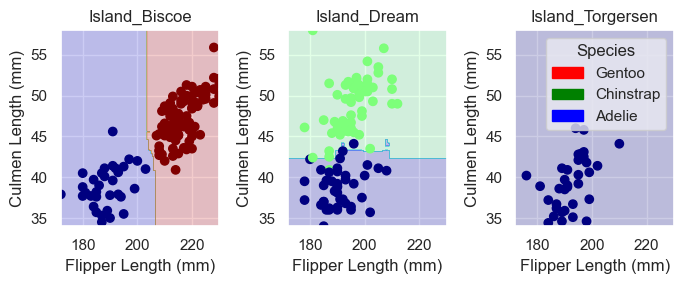

In [118]:
#| echo: false

plot_regions(dt_model, X_train[cols], y_train)

These plots show us how our model made its classifications. On the far left, we can see that for the Biscoe Island data, the model was able to correctly distinguish between the Adelie (blue) and Gentoo (red) penguins using the flipper length. Moving to the far right, on Torgensen Island, there are only Adelie penguins, so the model was able to classify all of them correctly. In the middle plot we can see that the penguins on Dream Island were harder to classify -- we can see where the model classified a Chinstrap (green) penguin as an Adelie penguin (blue) because it had a shorter culmen than the other Chinstrap penguins, causing its point to be within the blue region. 

### Discussion

We can see that our random forest was a very accurate model. It only misclassified one of the penguins, giving us 98.5% testing accuracy. We can see from the decision regions that the random forest was able to learn patterns within each island fairly well, even creating some accurate non-linear decision regions. In order to get more accuracy for the Dream island data, we would probably need to use another classification method that could learn the differences between the Chinstrap and Adelie penguins on Dream island. Or, going back to our initial visualizations, we could use an ensemble learning method that first uses one model to separate one species from the other two using the quantitative measurements and another that uses a qualitative feature like the island to distinguish between penguins with similar physical measurements. 